#### Imports

In [94]:
import pandas as pd # Pour la manipulation des données
import numpy as np # Pour les calculs numériques
from sklearn import tree # Pour les arbres de décision
from sklearn.tree import DecisionTreeClassifier # Pour les arbres de décision
import matplotlib.pyplot as plt # Pour les graphiques
from sklearn.model_selection import train_test_split # Pour séparer les données en ensembles d'entraînement et de test
from sklearn.linear_model import LinearRegression # Pour la régression linéaire
from sklearn.preprocessing import StandardScaler # Pour la normalisation des données
from sklearn.decomposition import PCA # Pour l'analyse en composantes principales
from sklearn.neural_network import MLPRegressor # Pour les réseaux de neurones
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Pour évaluer les modèles

# On load le dataset
df = pd.read_csv("listings.csv2.gz", compression='gzip')

#### Collecte de données
afficher nombre de colonnes et de lignes


In [265]:
print(f"Nombre de colonnes : {df.columns.__len__()}")
print(f"Nombre de lignes : {df.index.__len__()}")

## Pré-traitement des données

#### Supprimer les doublons

In [266]:
df = df.drop_duplicates()

#### Conversion des types de colonnes
- Conversion de Texte en Chiffres
- Extraction de Nombres
- Uniformisation des Données

In [267]:
# Nettoyage de la colonne "price"
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace("[^0-9.,]", "", regex=True)  # Retirer symboles
    .str.replace(",", ".", regex=False)        # Convertir en point
    .replace("", np.nan)                       # Remplacer chaînes vides par NaN
)

# Convertir en float avec gestion des erreurs
df["price"] = pd.to_numeric(df["price"], errors='coerce')

# Supprimer les lignes sans prix valide
df = df.dropna(subset=["price"])

#### Sélection des colonnes les plus pertinentes à évaluer

In [277]:
# Garder uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Supprimer les colonnes qui contiennent uniquement des NaN
numeric_df = numeric_df.dropna(axis=1, how='all')

# Supprimer toutes les lignes contenant des NaN
numeric_df = numeric_df.dropna()

# Calcul de corrélation avec la colonne "price"
correlations = numeric_df.corr()["price"].sort_values(ascending=False)

# Supprimer les corrélations NaN
correlations = correlations.dropna()

print(f"Corrélations : {correlations}")

# Sélection des colonnes pertinentes (corrélation > 0.2)
colonnes_pertinente = correlations[abs(correlations) > 0.2].index.tolist()

# On retire price de la liste si présent
colonnes_pertinente.remove("price")
print("==============")
print(f"Colonnes pertinentes : {colonnes_pertinente}")

Corrélations : price                                           1.000000
accommodates                                    0.570615
estimated_revenue_l365d                         0.533911
bedrooms                                        0.510061
beds                                            0.490273
bathrooms                                       0.477540
review_scores_cleanliness                       0.121519
availability_365                                0.119073
availability_eoy                                0.112342
review_scores_location                          0.102339
maximum_nights                                  0.081920
calculated_host_listings_count_entire_homes     0.081013
calculated_host_listings_count                  0.079608
host_listings_count                             0.075837
availability_90                                 0.071746
review_scores_rating                            0.069327
review_scores_value                             0.063399
host_total_listi

## Analyse descriptive des données

#### Relation entre la note globale et les prix des locations à Paris

#### Prix moyen par type de propriété à Paris

#### Prix en fonction de Location disponible à Paris

#### Répartition des locations disponible et non disponible pour Paris

## Entraînement (Regression lineaire)

#### Définition X et y

In [269]:
# Nettoyer df en supprimant les lignes avec des NaN dans les colonnes pertinentes
df_clean = df[colonnes_pertinente + ["price"]].dropna()

X = df_clean[colonnes_pertinente]
y = df_clean["price"]

#### Découpage train/test

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Entraînement du modèle

In [271]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Schéma pipeline

In [272]:
print("==== Schéma d'entraînement ====")
print("Features utilisées :", colonnes_pertinente)
print("Nombre d'éléments d'entraînement :", len(X_train))
print("Nombre d'éléments de test :", len(X_test))
print("Coef du modèle :", model.coef_)
print("Intercept :", model.intercept_)

==== Schéma d'entraînement ====
Features utilisées : ['accommodates', 'estimated_revenue_l365d', 'bedrooms', 'beds', 'bathrooms']
Nombre d'éléments d'entraînement : 41739
Nombre d'éléments de test : 10435
Coef du modèle : [ 2.58696948e+01  1.17796998e-03  3.43498997e+01 -5.98355500e+00
  6.20876267e+01]
Intercept : 0.293523800484337


#### Schéma graphique

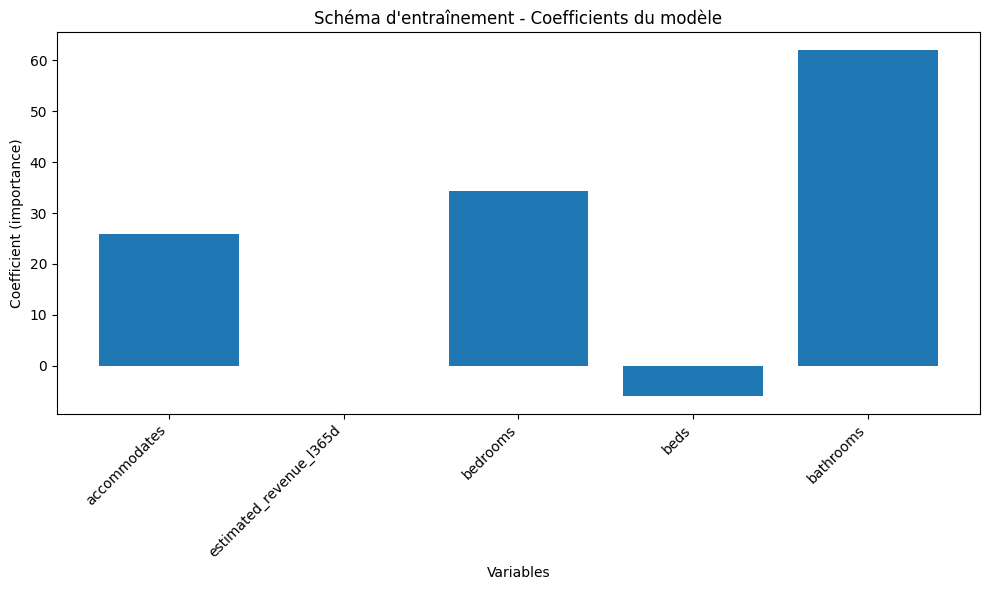

In [273]:
plt.figure(figsize=(10, 6))
plt.bar(colonnes_pertinente, model.coef_)
plt.xticks(rotation=45, ha="right")
plt.title("Schéma d'entraînement - Coefficients du modèle")
plt.xlabel("Variables")
plt.ylabel("Coefficient (importance)")
plt.tight_layout()
plt.show()

## Prédiction du prix (Regression lineair)

#### Prédiction

In [ ]:
y_pred = model.predict(X)
print("Prédictions exemple :", y_pred)

#### Prédiction schéma graphique (Données prédit vs Données réelles)

- Interprétation : Plus les points sont proches de la ligne rouge, meilleure est la prédiction du modèle

In [ ]:
plt.figure(figsize=(15, 8))

# Scatter plot des prix réels vs prix prédits
plt.scatter(y, y_pred, alpha=0.5, edgecolors='k', linewidth=0.5)

# Ligne diagonale (prédiction parfaite)
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')

plt.xlabel('Prix réels (€)', fontsize=12)
plt.ylabel('Prix prédits (€)', fontsize=12)
plt.title('Comparaison des prix prédits vs prix réels', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Prédiction sous forme de bar

In [ ]:
nombre_exemples_a_afficher = 20
plt.figure(figsize=(15, 7))
plt.bar(range(nombre_exemples_a_afficher), y[:nombre_exemples_a_afficher], alpha=0.5, label='Réel')
plt.bar(range(nombre_exemples_a_afficher), y_pred[:nombre_exemples_a_afficher], alpha=0.5, label='Prédit')
plt.legend()
plt.show()